<h2> Analysis of Movies by Season and Holiday - A breakdown of Profitability and Return on Investment</h2>

In addition to questions of Genre, Companies, Countries and Budget, and their relationship towards investment decisions made by moviemakers, I seek to answer the following questions:

<b>1. How does the Month of Movie Release affect Profits and Return on Investment (ROI)?</b>
<br>
<b>2. How are Profits and Return on Investment affected by Seasonality? Are there specific holidays that perform better than others?</b>

To answer these questions, I have decided to Web Scrape from the website www.The-Numbers.com, a movie industry data website that collects Box Office returns, including both Domestic and Worldwide Gross. The-Numbers.com provides tables consisting of 100 movies at a time. I was able to pull 5500 rows of Table data from 55 webpages. This is done by running the BeautifulSoup function to search available tables from the pulled HTML code. This function converts our information into a string, and utilizes the Pandas "read_html" function to read table data.

The F string function in our URL allows us to repeat this function x number of times in range(1,56), for a total of 55 iterations. The empty list in the function will return a series of dataframes, which are then concatenated. This webscraping technique is reserved for webpages that have a URL that is identical per page, except for the part of the URL that has increasing numbers in sequential pages as data is gathered.

For The-Numbers.com, this looks like: <br>
https://www.the-numbers.com/movie/budgets/all/101 <br>
https://www.the-numbers.com/movie/budgets/all/201 <br>
https://www.the-numbers.com/movie/budgets/all/301, etc.

In [7]:
#Import libraries
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from requests import get
import warnings
warnings.filterwarnings('ignore')

#Webscraping Function allows for 55 iterations of The Numbers Website, returning a list of dataframes that are then concatenated.
def webscrape():
    list_of_dfs=[]
    for x in range(1, 56):
        url = f"https://www.the-numbers.com/movie/budgets/all/{x}01"

        response = get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        page = soup.find_all('table')
        string = str(page[0])
        df = pd.read_html(string)[0]
        list_of_dfs.append(df)
    return list_of_dfs

df_lists = webscrape()
big_df = pd.concat(df_lists)

The returned Dataframe needs to be cleaned in order for us to pull aggregate data based on month and holiday weekend status. 

Our first transformation is to return numerical data from our Production Budget, Domestic Gross, and Worldwide Gross columns. This means that dollar signs and commas need to be removed and replaced as integers from 'non-null object' datatypes. We can also remove the 'Rank' column, which is not relevant to our questions.

To answer our questions, we need to create two columns - ROI, which is defined as Worldwide Gross divided by Production Budget, and Profit, which is defined as Worldwide Gross minus Production Budget. Profitability and ROI are key metrics to answering decisionmaking processes by movie producers.

We then address issues with our Release Date column - it is a 'non-null object' as well, and in order to categorize this information we have to first convert it into Datetime. From Datetime, we can convert our release dates into months, days, and years, which will allow us to sort for monthly splits as well as allowing us later to sort out holiday weekends in Pandas. Once in Pandas, we can aggregate holiday profability and ROI.

Finally, we have some values that need to be dropped. Out of the 5500 rows, only 5026 of them have a Domestic and Worldwide Gross above zero. We have dropped these rows from our dataset.

In [8]:
#Remove dollar signs and commas from our Production Budget, Domestic Gross, and Worldwide Gross
big_df['Production Budget'] = big_df['Production Budget'].str.replace("$", "")
big_df['Production Budget'] = big_df['Production Budget'].str.replace(",", "")
big_df['Domestic Gross'] = big_df['Domestic Gross'].str.replace("$", "")
big_df['Domestic Gross'] = big_df['Domestic Gross'].str.replace(",", "")
big_df['Worldwide Gross'] = big_df['Worldwide Gross'].str.replace("$", "")
big_df['Worldwide Gross'] = big_df['Worldwide Gross'].str.replace(",", "")
#Drop 'Rank' from our Columns
big_df.columns = ["Rank", "Release Date", "Movie", "Production Budget", "Domestic Gross", "Worldwide Gross"]
big_df.drop(columns = ["Rank"], inplace = True)
#Convert our necessary datatypes to Integers.
big_df["Production Budget"] = big_df["Production Budget"].astype(int)
big_df["Domestic Gross"] = big_df["Domestic Gross"].astype(int)
big_df["Worldwide Gross"] = big_df["Worldwide Gross"].astype(int)
#Creating new ROI and Profit columns for use in our graphs.
big_df["ROI"] = (big_df["Worldwide Gross"]/big_df["Production Budget"])-1
big_df["Profit"] = big_df["Worldwide Gross"] - big_df["Production Budget"]
#Convert Release Date to datetime and split columns into Month, Day and Year
big_df['Release Date'] =  pd.to_datetime(big_df['Release Date'], format='%b %d, %Y')
big_df['Month'] = big_df['Release Date'].dt.month
big_df['Day'] = big_df['Release Date'].dt.day
big_df['Year'] = big_df['Release Date'].dt.year
#Remove rows that have a Gross oF 0
moviedata = big_df[big_df['Domestic Gross'] != 0]
moviedata = moviedata[['Movie', 'Month','Day', 'Year', 'Production Budget', 'Domestic Gross', 'Worldwide Gross', 'ROI',
'Profit']]
moviedata = moviedata.sort_values(by="ROI", ascending = False)

It's also important to note that the movies taken from The-Numbers.com are top grossing movies, and that if we were to pull movie database information from a different data set, as has been done by my team members, we may see different information regarding Profitability and Return on Investment. So we want to make sure that we have the Mean and Median Production Budget and Worldwide Gross information from our database right off the bat.

In [9]:
print(moviedata['Production Budget'].mean())
print(moviedata['Production Budget'].median())
print(moviedata['Worldwide Gross'].mean())
print(moviedata['Worldwide Gross'].median())

31252105.34799045
20000000.0
90085897.5833665
35813016.0


Now that we have split the movie data values into months, we have sufficient information to gather profitability and ROI statistics by month. This is not yet true for our holiday data - we want to see whether certain holiday weekends are better or worse for profitability and ROI. To do this we need to define what we mean by holiday weekends. I have defined holiday weekends as releases that are 7 days prior to holidays that occur on the same time each year (such as Christmas), and the entire 7 day range for holidays that rotate days (such as Thanksgiving and Veterans Day).

The code below creates individual datasets for each holiday weekend. It then creates new 'Holiday' columns, allowing us to set labels for the weekends in which these films are released. Instead of creating datasets based on queries that list these date ranges, we have created filter variables. This allows for boolean filtering, which makes concatenating our individual holiday datasets with our majority 'non-holiday' dataset much easier.

In [75]:
#Filtering for New Years Day
filternewyears = ((moviedata['Month'] ==12) & (moviedata['Day'] >=26)) | ((moviedata['Month'] ==1) & (moviedata['Day'] ==1))
newyearsmovies = moviedata[filternewyears]
newyearsmovies['Holiday'] = "New Years Day"
#Filtering for Martin Luther King Jr. Day
filtermlk = ((moviedata['Month'] ==1) & (moviedata['Day'] >=15)) & (moviedata['Day'] <=21)
mlkmovies = moviedata[filtermlk]
mlkmovies['Holiday'] = 'MLK Day'
#Filtering for Memorial Day
filtermemorialday = ((moviedata['Month'] ==5) & (moviedata['Day'] >=25)) & (moviedata['Day'] <=31)
memorialdaymovies = moviedata[filtermemorialday]
memorialdaymovies['Holiday'] = 'Memorial Day'
#Filtering for Independence Day
filterindependenceday = ((moviedata['Month'] ==6) & (moviedata['Day'] >=28)) | ((moviedata['Month'] ==7) & (moviedata['Day'] ==4))
independencedaymovies = moviedata[filterindependenceday]
independencedaymovies['Holiday'] = '4th of July'
#Filtering for Labor Day
filterlaborday =  ((moviedata['Month'] ==9) & (moviedata['Day'] >=1)) & (moviedata['Day'] <=7)
labordaymovies = moviedata[filterlaborday]
labordaymovies['Holiday'] = 'Labor Day'
#Filtering for Halloween
filterhalloween = ((moviedata['Month'] ==10) & (moviedata['Day'] >=25)) & (moviedata['Day'] <=31)
halloweenmovies = moviedata[filterhalloween]
halloweenmovies['Holiday'] = 'Halloween'
#Filtering for Veterans Day
filterveteransday = ((moviedata['Month'] ==11) & (moviedata['Day'] >=6)) & (moviedata['Day'] <=12)
veteransdaymovies = moviedata[filterveteransday]
veteransdaymovies['Holiday'] = "Veterans Day"
#Filtering for Thanksgiving
filterthanksgiving = ((moviedata['Month'] ==11) & (moviedata['Day'] >=22)) & (moviedata['Day'] <=28)
thanksgivingmovies = moviedata[filterthanksgiving]
thanksgivingmovies['Holiday'] = 'Thanksgiving'
#Filtering for Christmas
filterchristmas = ((moviedata['Month'] ==12) & (moviedata['Day'] >=19)) & (moviedata['Day'] <=25)
christmasmovies = moviedata[filterchristmas]
christmasmovies['Holiday'] = 'Christmas'
#Creating our Non-Holiday Movies Category, which uses each of the previous filters as a series of negative queries to leave the remaining movies
nonholidaymovies = moviedata[~(filternewyears) & ~(filtermlk) & ~(filtermemorialday) & ~(filterindependenceday) & ~(filterlaborday) & ~(filterhalloween)
& ~(filterveteransday) & ~(filterthanksgiving) & ~(filterchristmas)]
nonholidaymovies['Holiday'] = 'No Holiday'
#Creating our new Dataframe, which is complete with a column describing the Holiday status (or lack thereof) of our movies.
holidayseries = pd.concat([nonholidaymovies, newyearsmovies, mlkmovies, memorialdaymovies, independencedaymovies, labordaymovies, 
halloweenmovies, veteransdaymovies, thanksgivingmovies, christmasmovies])
holidayseries.head()

,Movie,Month,Day,Year,Production Budget,Domestic Gross,Worldwide Gross,ROI,Profit,Holiday
8,Paranormal Activity,9,25,2009,450000,107918810,194183034,430.517853,193733034,No Holiday
22,The Blair Witch Project,7,14,1999,600000,140539099,248300000,412.833333,247700000,No Holiday
62,Bambi,8,13,1942,858000,102797000,268000000,311.354312,267142000,No Holiday
24,Rocky,11,21,1976,1000000,117235147,225000000,224.000000,224000000,No Holiday
52,Halloween,10,17,1978,325000,47000000,70000000,214.384615,69675000,No Holiday


The number of movies in each holiday category can be summarized by finding each 'Holiday' column's value counts, transposing to a horizontal display, and placing it to a dataframe. 

In [77]:
pd.DataFrame(holidayseries['Holiday'].value_counts()).transpose()

,No Holiday,Christmas,Veterans Day,Thanksgiving,New Years Day,Halloween,MLK Day,Labor Day,Memorial Day,4th of July
Holiday,4138,222,103,99,92,89,82,72,72,57


In [76]:
#Creating a small dataset measuring the value counts of number of months per year. We create a new column, 'Months', and reframed 
#the index into a new column.
monthamounts = moviedata['Month'].value_counts()
moviesbymonth = pd.DataFrame(monthamounts, columns=['Month'])
moviesbymonth['Months'] = moviesbymonth.index
moviesbymonth.columns = ['Amounts', 'Months']
moviesbymonths = moviesbymonth.sort_values(by='Months', ascending = True)

The plot below shows the number of movies in our dataset that were made each month. We can see that more movies tend to be released later in the year.

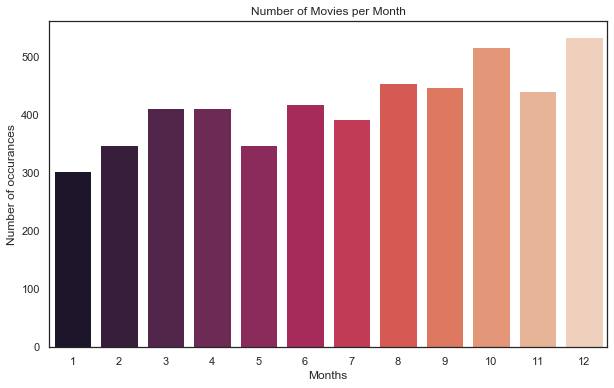

In [93]:
#Setting the bar chart
plt.figure(figsize=[10,6])
#Setting context to 'notebook' will keep the text small in Seaborn
sns.set_context("notebook")
sns.barplot(data=moviesbymonths, x='Months', y='Amounts',palette="rocket")
plt.xlabel('Months')
plt.ylabel('Number of occurances')
plt.title('Number of Movies per Month')
plt.show()

Now that we have the data necessary to answer our questions on profitability and ROI by month and holiday weekend, we need to collect summary statistics per month to discover our profits and ROI. To measure our monthly profits and ROI, we can use the 'groupby' method, which will allow us to organize summary statistics of one of our table columns from within a second selected column. Then we can perform a mathematical transformation to our summary data - mean and median are both selected below and can now be plotted in our bar graphs.

In [79]:
#Using Groupby to create summary data per month for both Mean and Median Profits
profitamounts = moviedata.groupby('Month').Profit.mean()
profitmedians = moviedata.groupby('Month').Profit.median()
#Creating Dataframes to store the results
moviesbyprofit = pd.DataFrame(profitamounts)
moviesbyprofit['Month'] = moviesbyprofit.index
moviesbyprofit.columns = ['Profits', 'Months']
moviesbyprofitmed = pd.DataFrame(profitmedians)
moviesbyprofitmed['Month'] = moviesbyprofitmed.index
moviesbyprofitmed.columns = ['Median Profits', 'Months']
#Using Groupby to create summary data per month for both Mean and Median ROI
#Construct Dataframes to store the results
roiamounts = moviedata.groupby('Month').ROI.mean()
moviesbyroi = pd.DataFrame(roiamounts)
moviesbyroi['Month'] = moviesbyroi.index
moviesbyroi.columns = ['ROI', 'Months']
roiamountsmed= moviedata.groupby('Month').ROI.median()
moviesbyroimed = pd.DataFrame(roiamountsmed)
moviesbyroimed['Month'] = moviesbyroi.index
moviesbyroimed.columns = ['Median ROI', 'Months']

Looking at our mean and median profits based on month of movie release, we can tell that there is a clear seasonality for blockbuster movie releases - May, June, and July are very strong months for average overall profits. November and December also mark a strong season for movie profits, and we can see that spring and fall months are generally lacking in mean and median profits.

One interesting discrepancy between mean and median profits that is worth noting is the month of May. We can see that median May profits lag far behing median June and July profits, but looking at the mean May profits we can see that it is one of the most profitable months.

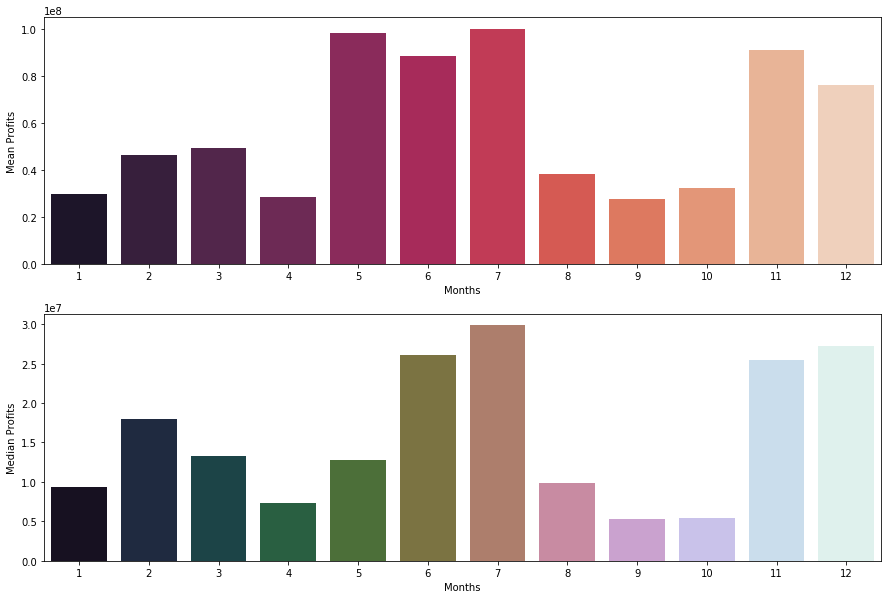

In [80]:
#Setting up a 2x1 bar chart showing Mean and Median Profits
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=False)
sns.barplot(data=moviesbyprofit, x='Months', y='Profits',palette="rocket", ax=ax1)
ax1.set_ylabel("Mean Profits")
sns.barplot(data=moviesbyprofitmed, x='Months', y='Median Profits',palette="cubehelix", ax=ax2)
ax2.set_ylabel("Median Profits")
plt.show()

While we see a clear seasonality to mean and median profits by month, this does not necessarily reflect our Return on Investment. Even most casual moviegoers are aware that summer blockbusters are the season where the most big movies come out, but investing in movies can return profits in any month. Looking at mean and median ROI amounts per month shows a more consistent correlation from month to month, suggesting that more low budget movies are released during off-seasons for movies that nevertheless can turn reliable profits in the industry. The timing of movie releases is a strategic decision driven largely by competition, so lower budget movies may be released during off-months to corner a smaller market share, which can still see a good ROI. However, ROI still remains strongest for the summer months and winter months, with July and November showing the highest mean and median Returns on Investment.

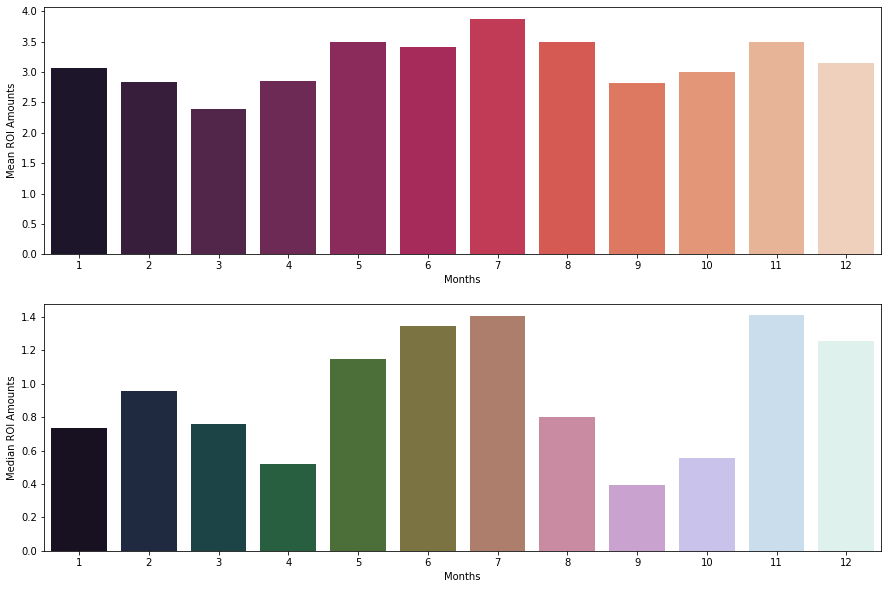

In [81]:
#Setting up a 2x1 bar chart showing Mean and Median ROI
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=False)
sns.barplot(data=moviesbyroi, x='Months', y='ROI',palette="rocket", ax=ax1)
ax1.set_ylabel("Mean ROI Amounts")
sns.barplot(data=moviesbyroimed, x='Months', y='Median ROI',palette="cubehelix", ax=ax2)
ax2.set_ylabel("Median ROI Amounts")
plt.show()

Month by month returns show clear relationships regarding profit and ROI trends in the movie industry. However, they may not reflect the smaller trends in the yearly movie cycle, which remain heavily based on indiviudal weekend release figures.

In our charts below, we will be analyzing major holiday weekends to see how they affect profitability and ROI. Holidays mark clear points of demarkation for the movie cycle, and can show more targeted results for well-performing and poorly-performing weeks. 

We have divided our holiday weekends in to New Years Day, Martin Luther King Jr. Day, Memorial Day, Independence Day, Labor Day, Halloween, Veterans Day, Thanksgiving, and Christmas. We need to comapare these against all other weekends, marked as 'No Holiday'. Like we did before with individual months, we can create separate dataframes using the 'groupby' function to show our summary statistics.

In [82]:
#Create dataframe for Holiday movies by mean profits
holidayprofitsmean = holidayseries.groupby('Holiday').Profit.mean()
holidaymoviesbyprofit = pd.DataFrame(holidayprofitsmean)
holidaymoviesbyprofit['Holiday'] = holidaymoviesbyprofit.index
holidaymoviesbyprofit.columns = ['Profits', 'Holiday']
#Create dataframe for Holiday movies by mean ROI
holidayROImean = holidayseries.groupby('Holiday').ROI.mean()
holidaymoviesbyROI = pd.DataFrame(holidayROImean)
holidaymoviesbyROI['Holiday'] = holidaymoviesbyROI.index
holidaymoviesbyROI.columns = ['ROI', 'Holiday']
#Create dataframe for Holiday movies by median profits
holidayprofitsmedian = holidayseries.groupby('Holiday').Profit.median()
holidaymoviesbyprofitmed = pd.DataFrame(holidayprofitsmedian)
holidaymoviesbyprofitmed['Holiday'] = holidaymoviesbyprofit.index
holidaymoviesbyprofitmed.columns = ['Profits', 'Holiday']
#Create dataframe for Holiday movies by median ROI
holidayROImedian = holidayseries.groupby('Holiday').ROI.median()
holidaymoviesbyROImed = pd.DataFrame(holidayROImedian)
holidaymoviesbyROImed['Holiday'] = holidaymoviesbyROI.index
holidaymoviesbyROImed.columns = ['ROI', 'Holiday']

Holiday weekend data shows strong correlations between the weekend of box office movie release and mean and median profit amounts. In the bar graphs below, we can see which holidays are profitable and which ones are not. We can also compare individual holiday weekend releases to the means and medians of non-holiday weekend releases.

The summary data here shows us that Memorial Day weekend is by far the strongest performer among holiday weekend movies, and that Labor Day, MLK Day, Halloween and New Years Day actually perform worse at the box office than the average non-holiday weekend. Independence Day also performs well, and we see continued correlation between Holiday weekends that fall within the well-performing months of May, June, July, November, and December and increased profitability.

We also see a rather large gap between mean and median profitability for Halloween weekend, which may be explained by the prevalence of low-budget Horror films that tend to be released around that time.

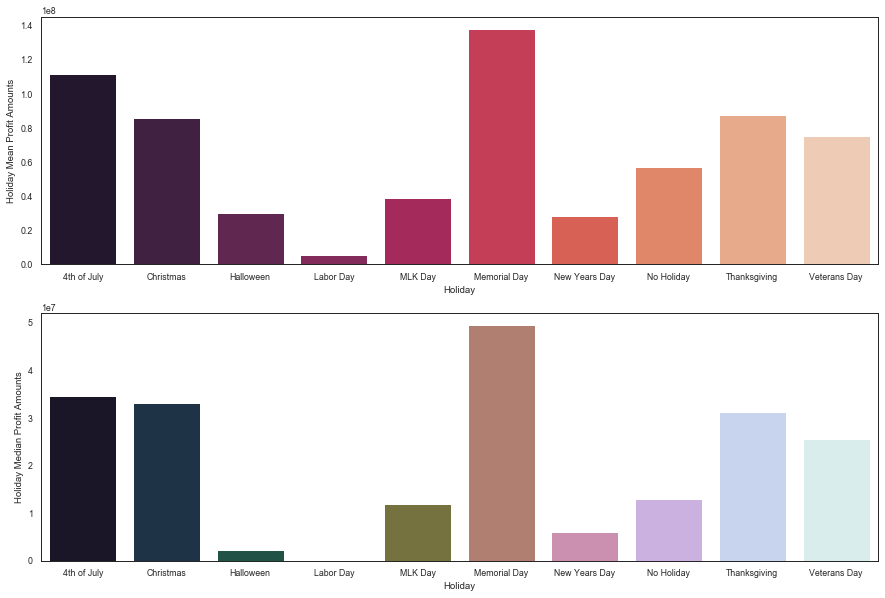

In [91]:
#Setting up a 2x1 chart showing mean and median profit amounts by holiday
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=False)
sns.barplot(data=holidaymoviesbyprofit, x='Holiday', y='Profits',palette="rocket", ax=ax1)
ax1.set_ylabel("Holiday Mean Profit Amounts")
sns.barplot(data=holidaymoviesbyprofitmed, x='Holiday', y='Profits',palette="cubehelix", ax=ax2)
ax2.set_ylabel("Holiday Median Profit Amounts")
plt.show()

ROI results for our holiday data tell a slightly different story. While Memorial Day still leads the pack in terms of ROI, it is closely followed by New Years Day, which was far behind even non-holidays in terms of mean and median profitability. This suggests that New Years Day is a good time to release low budget movies.

Halloween movies also see an increase in ROI versus profitability, although even in ROI there is a large gap between Halloween movies' mean ROI versus their median. 

Christmas, Thanksgiving, and Veterans Day movies each see their average ROI worse than non-holiday movies, although the median ROI for Christmas, Thanksgiving, and Veterans Day movies is still considerably better than non-holiday movies. 

Labor Day movies are by far the lowest performing movies in terms of ROI, and we notice that the median ROI for Labor Day movies is in the negative, which means that the median Labor Day movie is actually losing money.

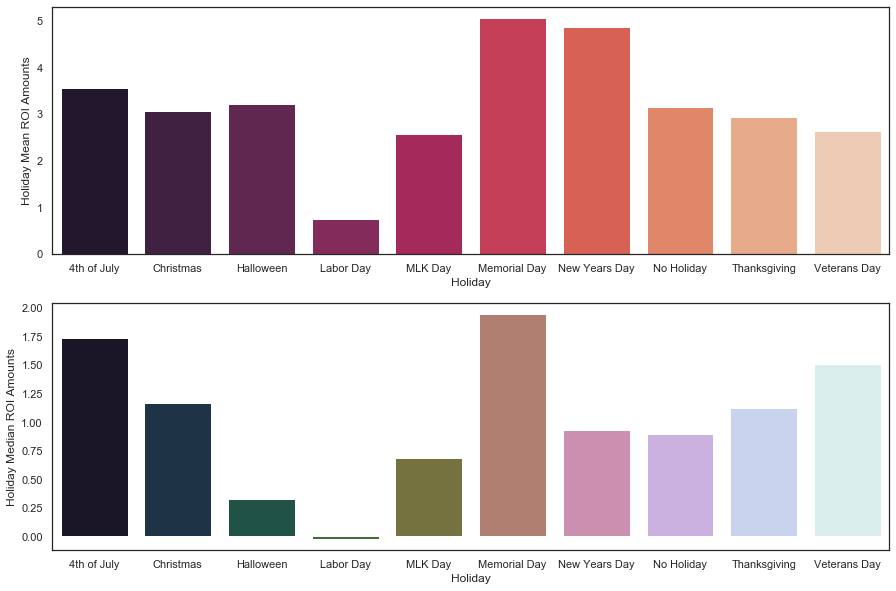

In [92]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=False)
sns.barplot(data=holidaymoviesbyROI, x='Holiday', y='ROI',palette="rocket", ax=ax1)
ax1.set_ylabel("Holiday Mean ROI Amounts")
sns.barplot(data=holidaymoviesbyROImed, x='Holiday', y='ROI',palette="cubehelix", ax=ax2)
ax2.set_ylabel("Holiday Median ROI Amounts")
plt.show()

<h2>Data Summary and Conclusion</h2>

The summary graphs in our dataset can answer our critical questions:
<p><b>1. How does the Month of Movie Release affect Profits and Return on Investment (ROI)?</b>
<br>
-Movie release months are most profitable and have the highest Return on Investment in the summer months and in November/December. This gap is palpable when it comes to profits but is more constrained when it comes to Return on Investment. The largest gap between Mean and Median profitability comes in the month of May, which shows a high Mean profitability but a significantly lower Median profitability.

<b>2. How are Profits and Return on Investment affected by Seasonality? Are there specific holidays that perform better than others?</b>
<br>
-Holiday weekends that show a higher Mean and Median Profitability than non-holiday weekends include Memorial Day, 4th of July, Christmas, Thanksgiving, and Veterans Day. Holiday weekends that show a lower Mean and Median Profitabiltiy than non-holiday weekends include New Years Day, Martin Luther King Jr. Day, Halloween, and Labor Day, with Labor Day showing by far the worst performances.

-Holiday weekends that show a higher Mean and Median ROI than non-holiday weekends include Memorial Day, New Years Day, and 4th of July. Veterans Day, Thanksgiving, and Christmas show a lower Mean ROI but a higher Median ROI than non-holiday weekends. Halloween shows a higher Mean ROI but a lower Median ROI than non-holiday weekends. Labor Day and Martin Luther King Jr. Day show both lower Mean and lower Median ROIs than non-holiday weekends.
    
<b>What insights can we gather from this data?</b>
<p>
    - It is a good idea to try to release your movie during the summer months or the winter months, and creating a movie that can compete with the blockbusters that are generally released during Memorial Day weekend is a good strategy for both Return on Investment as well as profitability.
